In [102]:
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import glob
import imageio
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
from tqdm import trange, notebook 
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint

In [109]:
# 하이퍼 파라미터
BATCH_SIZE = 1
IMAGE_SIZE = 64
EPOCH = 50


# 데이터 경로
dataset_A_dir = './datasets/face/celeba/Dataset/trainA'
dataset_B_dir = './datasets/face/celeba/Dataset/trainB'
checkpoint_dir = './checkpoint/'
results_dir = './results/'
weights_dir = './weights/'

In [110]:
# 데이터 불러오기
data_generator = ImageDataGenerator(rescale=1./255)


trainA_generator = data_generator.flow_from_directory(
    dataset_A_dir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=1)

trainB_generator = data_generator.flow_from_directory(
    dataset_B_dir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=1)

Found 11542 images belonging to 3 classes.
Found 11542 images belonging to 3 classes.


In [111]:
# 데이터셋에서 이미지만 가져오기
n_A = trainA_generator.n
steps = n_A // BATCH_SIZE

imgs_A, labels_A = [], []
for i in notebook.tqdm(range(steps)):
    a, b = trainA_generator.next()
    imgs_A.extend(a)
    labels_A.extend(b)

imgs_A = np.asarray(imgs_A)
labels_A = np.asarray(labels_A)

n_B = trainB_generator.n
steps = n_B // BATCH_SIZE

imgs_B, labels_B = [], []
for i in notebook.tqdm(range(steps)):
    a, b = trainB_generator.next()
    imgs_B.extend(a)
    labels_B.extend(b)

imgs_B = np.asarray(imgs_A)
labels_B = np.asarray(labels_A)


dataset_A = tf.data.Dataset.from_tensor_slices(imgs_A).batch(BATCH_SIZE)
dataset_B = tf.data.Dataset.from_tensor_slices(imgs_B).batch(BATCH_SIZE)

  0%|          | 0/11542 [00:00<?, ?it/s]

  0%|          | 0/11542 [00:00<?, ?it/s]

In [112]:
# 이미지 데이터셋 저장

# 저장할 파일 경로
save_path_A = './datasets/face/trainA'
save_path_B = './datasets/face/trainB'

# 데이터셋 A 저장
tf.data.experimental.save(dataset_A, save_path_A)

# 데이터셋 B 저장
tf.data.experimental.save(dataset_B, save_path_B)

In [113]:
# 저장할 파일 경로
save_path_A = './datasets/face/celeba/Dataset/trainA'
save_path_B = './datasets/face/celeba/Dataset/trainB'

# 데이터셋 A 불러오기
dataset_A = tf.data.experimental.load(save_path_A)

# 데이터셋 B 불러오기
dataset_B = tf.data.experimental.load(save_path_B)

In [114]:
# 판별자 A - 도메인 A를 판별

discriminator_A = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator_A",
)
discriminator_A.summary()

Model: "discriminator_A"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_51 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_46 (Conv2D)          (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_61 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_52 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                  

In [115]:
# 판별자 B - 도메인 B를 판별

discriminator_B = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator_B",
)
discriminator_B.summary()

Model: "discriminator_B"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_64 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_55 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_50 (Conv2D)          (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_65 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 batch_normalization_56 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                  

In [116]:
# 생성자 - 랜덤 벡터를 입력으로 받아 도메인 A, B의 특성을 모두 갖는 이미지 생성

latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(4 * 4 * 512),
        layers.Reshape((4, 4, 512)),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 8192)              1056768   
                                                                 
 reshape_6 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 8, 8, 256)        2097408   
 Transpose)                                                      
                                                                 
 leaky_re_lu_68 (LeakyReLU)  (None, 8, 8, 256)         0         
                                                                 
 batch_normalization_59 (Bat  (None, 8, 8, 256)        1024      
 chNormalization)                                                
                                                                 
 conv2d_transpose_22 (Conv2D  (None, 16, 16, 128)      52

In [117]:
# GAN model

class GAN(keras.Model):
    def __init__(self, discriminator_A, discriminator_B, generator, latent_dim):
        super().__init__()
        self.discriminator_A = discriminator_A
        self.discriminator_B = discriminator_B
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, dA_optimizer, dB_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.dA_optimizer = dA_optimizer
        self.dB_optimizer = dB_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.dA_loss_metric = keras.metrics.Mean(name="dA_loss")
        self.dB_loss_metric = keras.metrics.Mean(name="dB_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.dA_loss_metric, self.dB_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        real_images_A, real_images_B = real_images
        
        # Sample random points in the latent space
        batch_size = tf.shape(real_images_A)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images_A = tf.concat([generated_images, real_images_A], axis=0)
        combined_images_B = tf.concat([generated_images, real_images_B], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator_A
        with tf.GradientTape() as tape:
            predictions_A = self.discriminator_A(combined_images_A)
            dA_loss = self.loss_fn(labels, predictions_A)
        grads = tape.gradient(dA_loss, self.discriminator_A.trainable_weights)
        self.dA_optimizer.apply_gradients(
            zip(grads, self.discriminator_A.trainable_weights)
        )
        
        # Train the discriminator_B
        with tf.GradientTape() as tape:
            predictions_B = self.discriminator_B(combined_images_B)
            dB_loss = self.loss_fn(labels, predictions_B)
        grads = tape.gradient(dB_loss, self.discriminator_B.trainable_weights)
        self.dB_optimizer.apply_gradients(
            zip(grads, self.discriminator_B.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions_A = self.discriminator_A(self.generator(random_latent_vectors))
            predictions_B = self.discriminator_B(self.generator(random_latent_vectors))
            g_loss_A = self.loss_fn(misleading_labels, predictions_A)
            g_loss_B = self.loss_fn(misleading_labels, predictions_B)
            g_loss = g_loss_A + g_loss_B
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.dA_loss_metric.update_state(dA_loss)
        self.dB_loss_metric.update_state(dB_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "dA_loss": self.dA_loss_metric.result(),
            "dB_loss": self.dB_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [118]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(checkpoint_dir+"generated_img_%03d_%d.png" % (epoch, i))


In [119]:
# 가중치 저장

checkpoint_path = weights_dir + "weights.{epoch:02d}.h5"


checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_freq='epoch',
    period=5
)

In [120]:
# GAN 학습

combined_dataset = tf.data.Dataset.zip((dataset_A, dataset_B))

gan = GAN(discriminator_A=discriminator_A, discriminator_B=discriminator_B, generator=generator, latent_dim=latent_dim)
gan.compile(
    dA_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    dB_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    combined_dataset, epochs=EPOCH, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim), checkpoint_callback]
)

Epoch 1/50
11542/11542 [==============================] - 386s 33ms/step - dA_loss: 0.4389 - dB_loss: 0.4821 - g_loss: 3.7011
Epoch 2/50
11542/11542 [==============================] - 436s 38ms/step - dA_loss: 0.3304 - dB_loss: 0.4383 - g_loss: 4.7432
Epoch 3/50
11542/11542 [==============================] - 445s 39ms/step - dA_loss: 0.2602 - dB_loss: 0.4180 - g_loss: 5.5195
Epoch 4/50
11542/11542 [==============================] - 466s 40ms/step - dA_loss: 0.2643 - dB_loss: 0.4445 - g_loss: 5.3087
Epoch 5/50
11542/11542 [==============================] - 455s 39ms/step - dA_loss: 0.3242 - dB_loss: 0.5287 - g_loss: 4.1885
Epoch 6/50
11542/11542 [==============================] - 441s 38ms/step - dA_loss: 0.3596 - dB_loss: 0.5572 - g_loss: 3.7768
Epoch 7/50
11542/11542 [==============================] - 436s 38ms/step - dA_loss: 0.3703 - dB_loss: 0.5690 - g_loss: 3.5912
Epoch 8/50
11542/11542 [==============================] - 448s 39ms/step - dA_loss: 0.3633 - dB_loss: 0.5583 - g_loss:

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

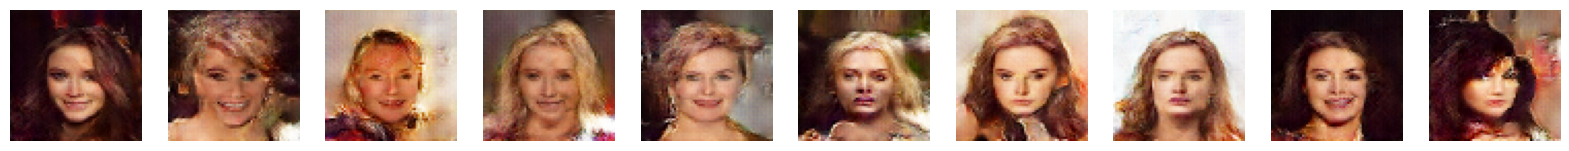

In [135]:
# 모델 테스트

# 테스트할 이미지 개수
num_test_images = 10

# 잠재 공간에서 무작위 벡터 생성
random_latent_vectors = tf.random.normal(shape=(num_test_images, latent_dim))

# 생성기를 사용하여 이미지 생성
generated_images = generator(random_latent_vectors)

# 생성된 이미지를 시각화
fig, axs = plt.subplots(1, num_test_images, figsize=(20, 20))
for i in range(num_test_images):
    axs[i].imshow(generated_images[i])
    axs[i].axis('off')
    img = keras.utils.array_to_img(generated_images[i])
    img.save(results_dir+"generated_img_%d.png" % (i))
plt.show()
